<a href="https://colab.research.google.com/github/n-young88/data/blob/main/06_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주성분 분석
# 차원과 차원 축소

주성분 분석 = PCA
- 데이터에 있는 분산이 큰 방향을 찾는 것

In [1]:
# PCA 클래스
!wget https://bit.ly/fruits_300_data -O fruits_300.npy
import numpy as np
fruits = np.load('fruits_300.npy')
fruits_2d = fruits.reshape(-1, 100*100)

--2023-11-12 07:32:49--  https://bit.ly/fruits_300_data
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy [following]
--2023-11-12 07:32:49--  https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy [following]
--2023-11-12 07:32:49--  https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conne

In [2]:
# sklearn.decomposition의 PCA 클래스
# n_components 매개변수에 주성분 개수를 지정해야한다.

from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(fruits_2d)

PCA(n_components=50)

In [3]:
# PCA가 찾은 주성분은 components_ 속성에 저장되어 있음
print(pca.components_.shape)

(50, 10000)


In [5]:
# 각 클러스터가 어떤 이미지를 나타냈는지 그림으로 출력 : draw_fruits() 만들기
import matplotlib.pyplot as plt

#(샘플개수, 너비, 높이)의 3차원 배열을 입력 받아 가로로 10개씩 이미지를 출력
def draw_fruits(arr, ratio = 1):
  n = len(arr) #n은 샘플의 개수
  # 한 줄에 10개씩 이미지를 그림, 샘플 개수를 10으로 나누어 행 개수를 계산
  rows = int(np.ceil(n/10))
  # 행이 1개이면 열의 개수는 샘플 개수, 그렇지 않으면 10개
  cols = n if rows < 2 else 10
  fig, axs = plt.subplots(rows, cols,
                          figsize=(cols*ratio, rows*ratio), squeeze=False)
  for i in range(rows):
    for j in range(cols):
      if i*10 + j<n:
        axs[i, j].imshow(arr[i*10+j], cmap='gray_r')
      axs[i,j].axis('off')
plt.show()

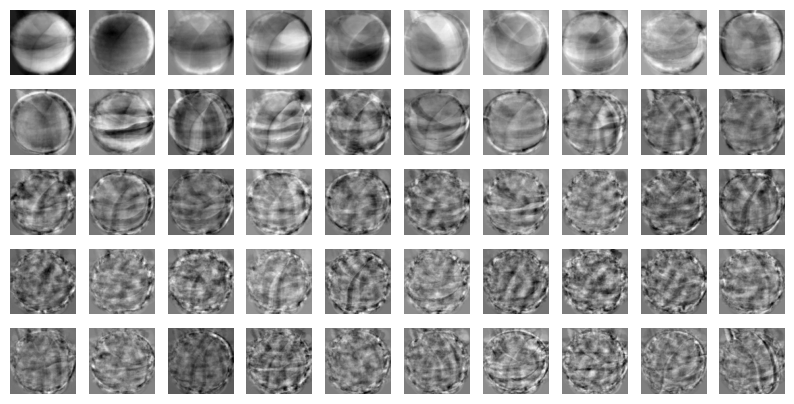

In [6]:
# 50개의 주성분을 찾음, 두번째 차원은 원본 데이터 개수와 같은 10000.
# 주성분을 100*100 크기의 이미지로 출력
draw_fruits(pca.components_.reshape(-1, 100, 100))

이제 원본 데이터를 주성분에 투영하여 특성의 개수를 10,000개에서 50개로 줄이자
원본 데이터를 각 주성분으로 분해하는 것.

In [7]:
# pca의 transform() 메서드 사용
print(fruits_2d.shape)

(300, 10000)


In [9]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 50)


1/200으로 줄어듬! 10,000 > 50

이제 원상 복구 해보자..

# 원본 데이터 재구성

In [10]:
# inverse_transform()
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


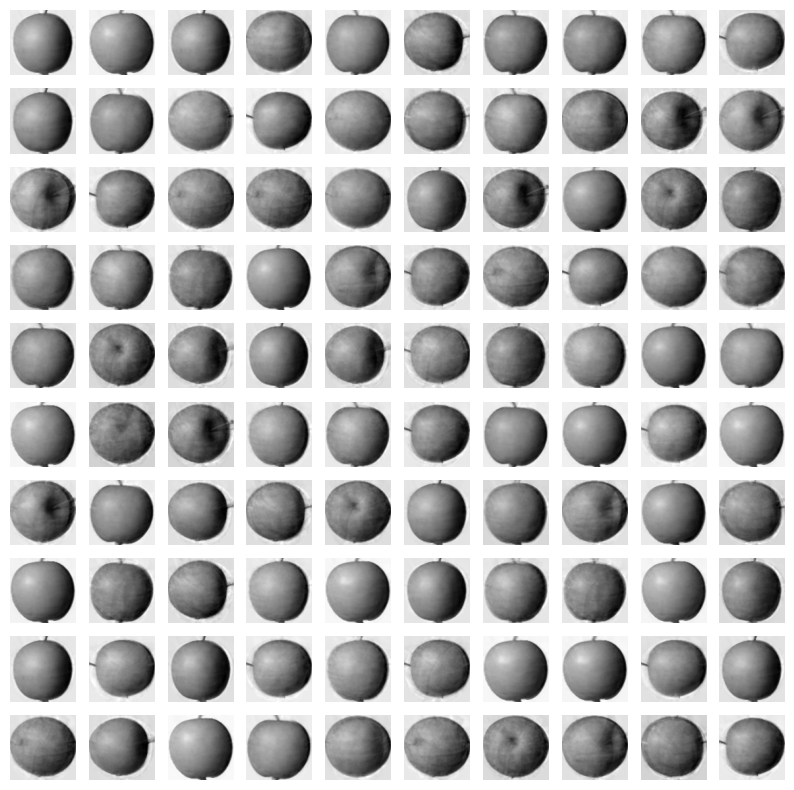

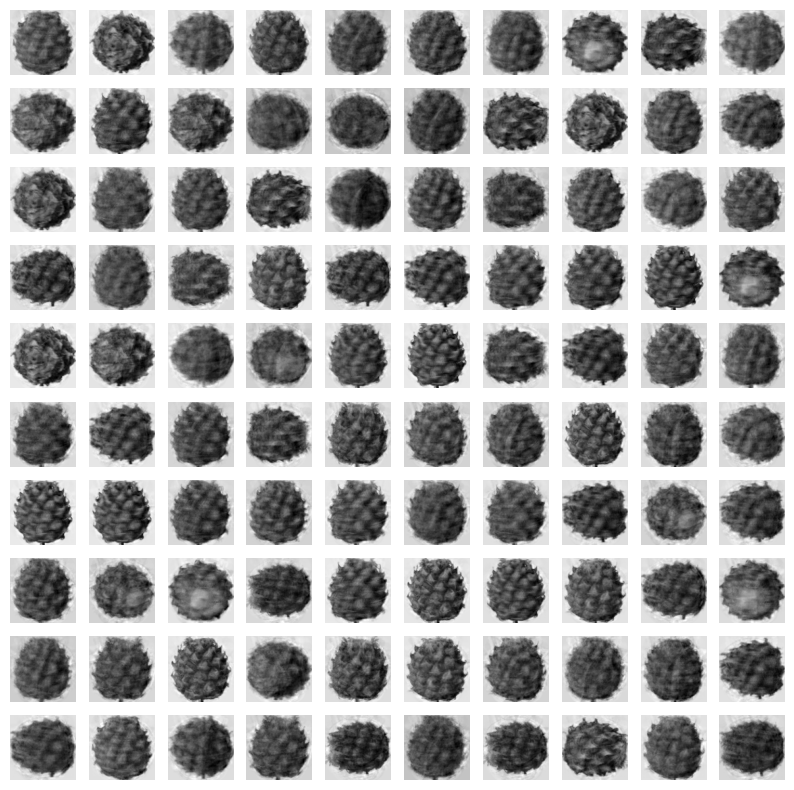

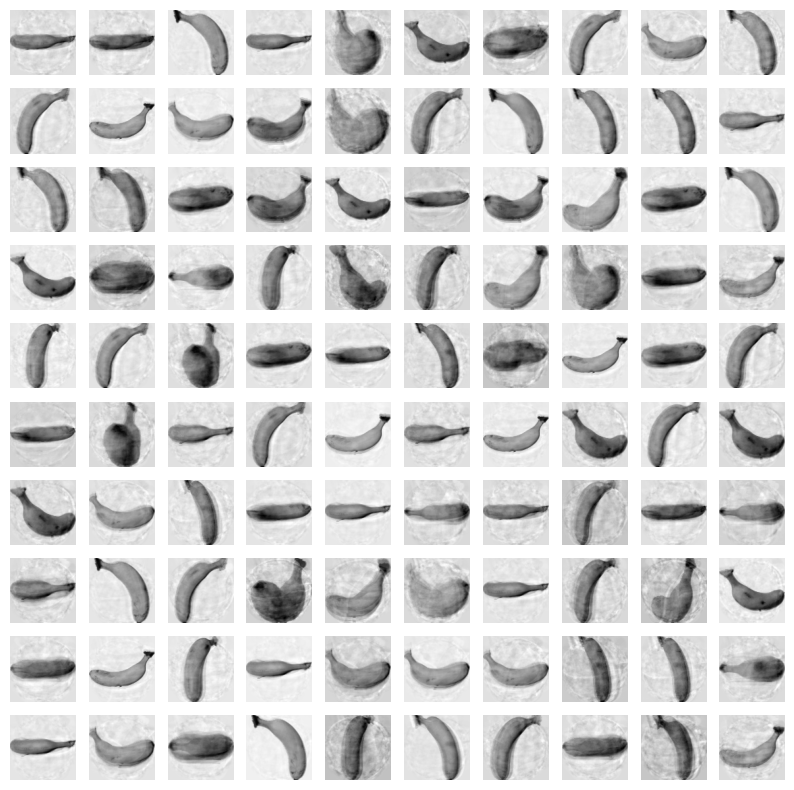

In [11]:
# 100*100 크기로 100개씩 나누어 출력
fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)
for start in [0, 100, 200]:
  draw_fruits(fruits_reconstruct[start:start+100])
  print("\n")

설명된 분산 : 주성분이 원본 데이터의 분산을 얼마나 잘 나타내는 지 기록한 값
- explained_variance_ratio_ : 주성분의 설명된 분산 비율이 기록 됨
- 이 분산 비율을 모두 더하면 50개의 주성분으로 표현하고 있는 총 분산 비율을 얻을 수 있음

In [12]:
print(np.sum(pca.explained_variance_ratio_))

0.9215923514023951


92%가 넘는 분산을 유지함

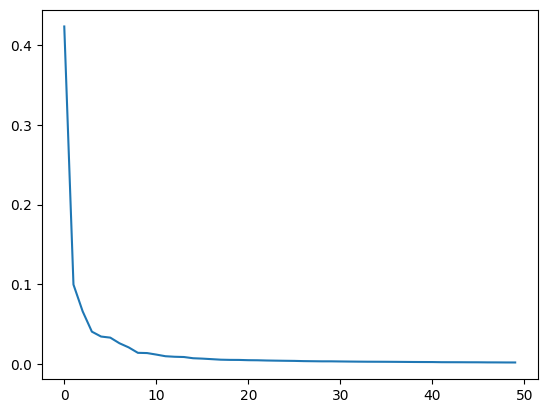

In [13]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

PCA로 차원 축소된 데이터를 사용하여 지도학습모델을 훈련하여 원본 데이터를 사용했을 때 어떤 차이가 있는지 확인해보자

# 다른 알고리즘과 함께 사용하기

In [14]:
# 3개의 과일 사진을 분류해야 하므로 로지스틱 회귀 모델을 사용
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [17]:
# 지도학습 - 타깃값
# 사과 0, 파인애플 1, 바나나 2로 지정
target = np.array([0]*100 + [1]*100 + [2]*100)

In [20]:
# 교차 검증 : cross_validate()
from sklearn.model_selection import cross_validate
scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score']))
# 훈련 시간
print(np.mean(scores['fit_time']))

0.9966666666666667
1.7226833820343017


In [21]:
# pca로 축소한 fruits_pca를 사용했을 때와 비교해보자
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

1.0
0.042025279998779294


50개의 특성만 사용했는데 정확도가 100%이고, 시간도 20배 이상 감소함

In [22]:
# PCA 클래스 n_components 매개변수에 주성분 개수를 지정하는 대신 원하는 설명된 분산의 비율을 지정할 수 있음
# 지정된 비율에 도달할 때까지 자동으로 주성분을 찾음
# 설명된 분산의 50%에 달하는 주성분을 찾도록 해보자

pca = PCA(n_components=0.5)
pca.fit(fruits_2d)

PCA(n_components=0.5)

In [24]:
print(pca.n_components_)

2


2개로 원본 데이터의 분산 50%를 표현할 수 있음

In [25]:
# 위 데이터로 원본 데이터 변환
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [28]:
# 교차검증
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9933333333333334
0.027926206588745117


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

2개의 특성을 사용해서 99%의 정확도를 달성함

In [31]:
# 차원 축소된 데이터를 사용해 k-평균 알고리즘으로 클러스터를 찾아보자
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)
print(np.unique(km.labels_, return_counts=True))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0, 1, 2], dtype=int32), array([110,  99,  91]))


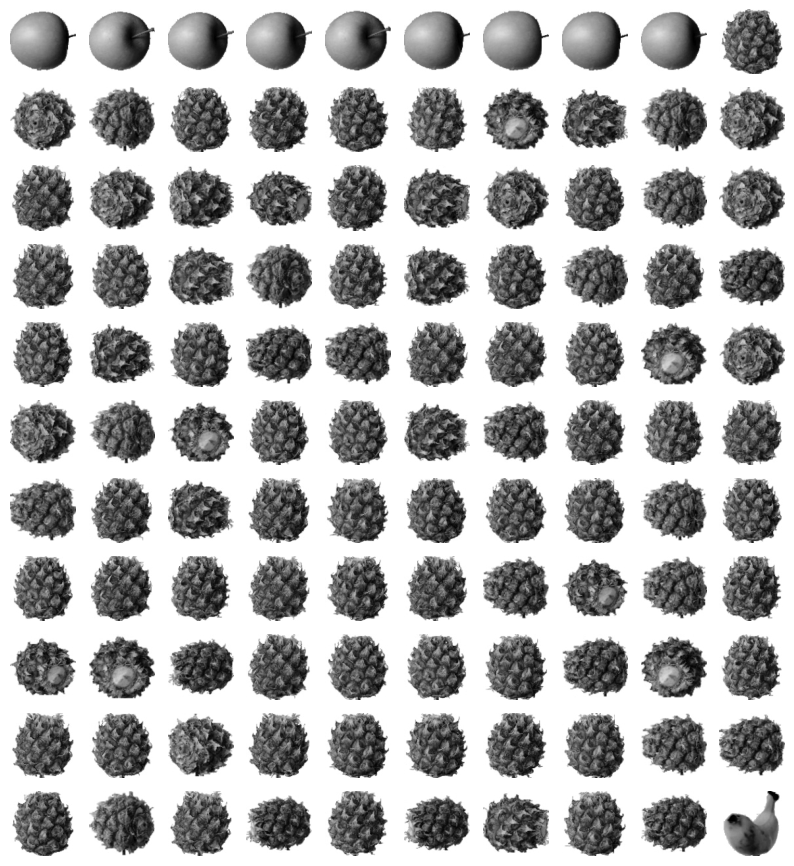

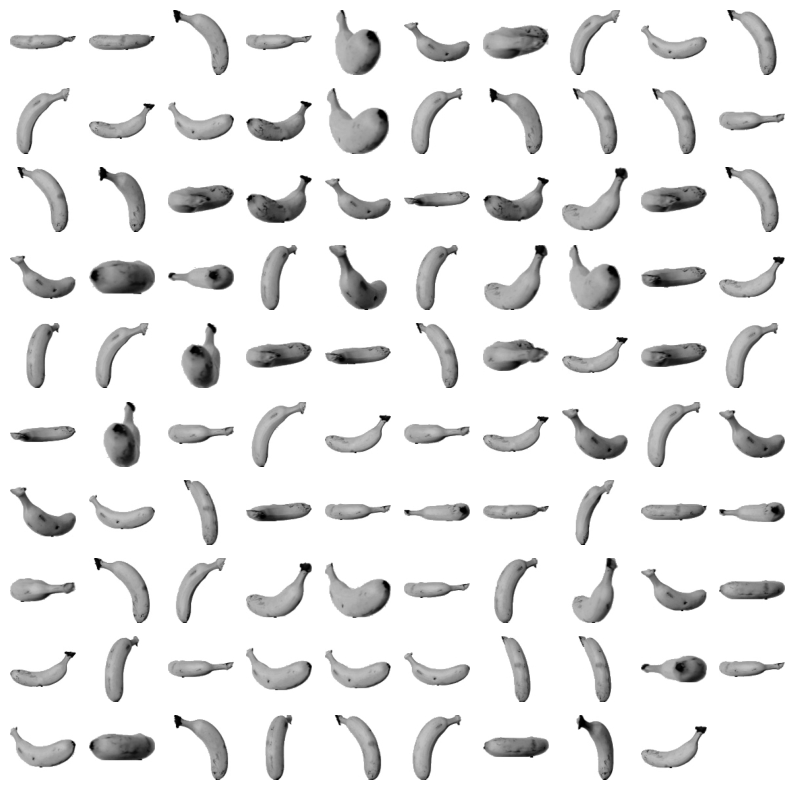

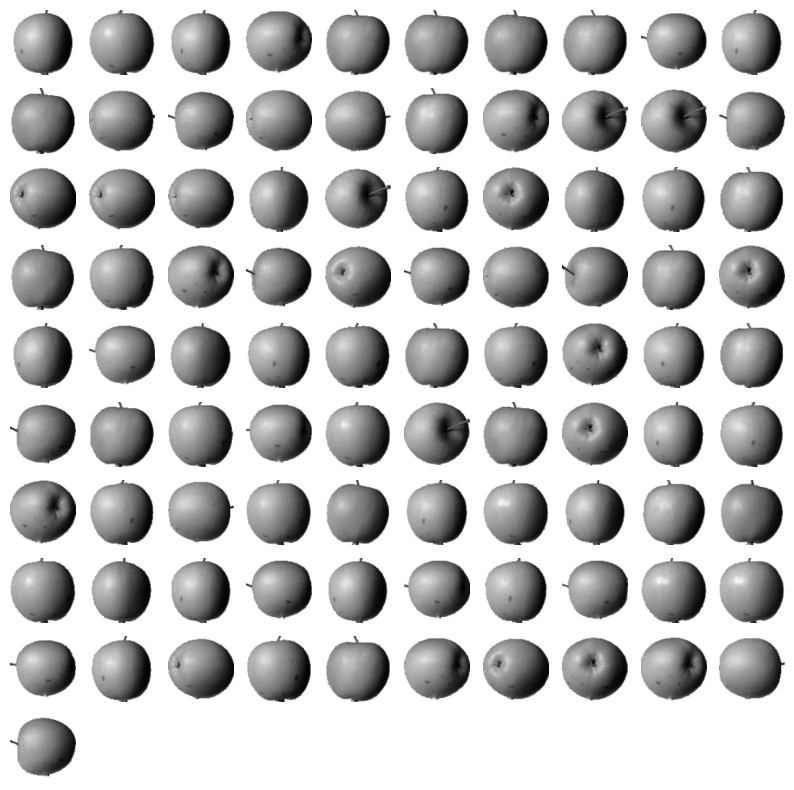

In [32]:
for label in range(0, 3):
  draw_fruits(fruits[km.labels_==label])
  print("\n")

차원 축소 장점 중 하나는 시각화

3개 이하로 차원을 줄이면 화면에 출력하기 쉽다

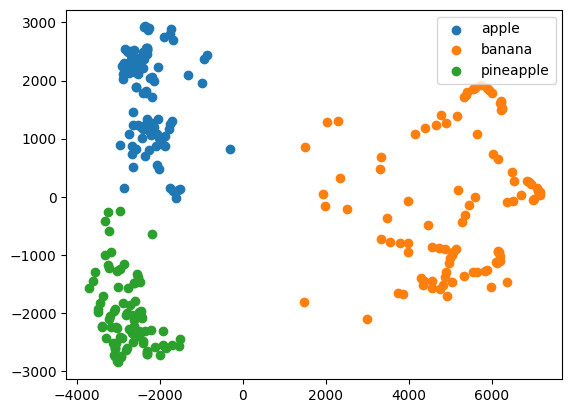

In [33]:
for label in range(0, 3):
  data = fruits_pca[km.labels_ == label]
  plt.scatter(data[:,0], data[:,1])
plt.legend(['apple','banana','pineapple'])
plt.show()

구분이 잘됨!